In [1]:
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import null_space

In [2]:
class SimplicialComplex:
    def __init__(self, all_simplices, is_sorted=False):
        """
        Initialize a simplicial complex.

        Args:
            all_simplices: A list of tuples representing the simplices (each tuple is a simplex).
            is_sorted: A boolean flag indicating if the simplices are already sorted.
        
        Raises:
            ValueError: If the input is not a valid simplicial complex.
        """
        # Sort the vertices in each simplex if not sorted
        if not is_sorted:
            all_simplices = [tuple(sorted(simplex)) for simplex in all_simplices]
        
        # Ensure the input forms a valid simplicial complex
        if not self._is_simplicial_complex(all_simplices):
            raise ValueError("The input set is not a valid simplicial complex.")
        
        # Store simplices in the complex
        self.all_simplices = all_simplices
        # The dimension of the simplicial complex is determined by the maximum simplex dimension
        self.dimension = len(max(all_simplices, key=len)) - 1
        # Group simplices by their dimension
        self.dim_simplices = self._sort_simplices_by_dimension()

    def process_complex(self):
        """
        Processes the simplicial complex by computing incidence matrices, persistence pairs, 
        and homology groups.
        """
        # Sort and flatten the simplices into a single list
        self.all_simplices = [simplex for dim in self.dim_simplices for simplex in dim]
        # Build incidence matrices for the complex
        self.incidence_matrices = self._build_incidence_matrix()
        # Reduce the incidence matrices to find persistence pairs
        self.reduced_incidence_matrices = self._build_reduced_incidence_matrix()
        # Compute finite persistence pairs
        self.finite_persistence_pairs = self._finite_persistence_pairs()
        # Compute infinite persistence pairs
        self.infinite_persistence_pairs = self._infinite_persistence_pairs()
        # Compute homology groups based on persistence pairs
        self.homology = self._homology()

    def _sort_simplices_by_dimension(self):
        """
        Sorts and groups simplices by their dimension.

        Returns:
            A list of lists, where each sublist contains simplices of a specific dimension.
        """
        # Group simplices by their dimension
        return [sorted([simplex for simplex in self.all_simplices if len(simplex) == i])
                for i in range(1, self.dimension + 2)]

    def _is_simplicial_complex(self, all_simplices):
        """
        Checks whether the input forms a valid simplicial complex.

        A valid simplicial complex must contain all faces of each simplex.

        Args:
            all_simplices: A list of simplices.
        
        Returns:
            bool: True if the input forms a valid simplicial complex, False otherwise.
        """
        for simplex in all_simplices:
            # Single vertices (0-simplices) are always valid
            if len(simplex) == 1:
                continue
            # For higher-dimensional simplices, check that all faces (subsets) are present
            for i in range(len(simplex)):
                # Create a face by removing one vertex from the simplex
                face = simplex[:i] + simplex[i+1:]
                if face not in all_simplices:
                    return False  # The face must be present in the simplicial complex
        return True
    
    def _build_incidence_matrix(self):
        """
        Builds the incidence matrices for the simplicial complex.

        The incidence matrix represents the boundary relations between k-simplices and (k+1)-simplices.
        A boundary matrix encodes which (k-1)-simplices are faces of k-simplices.

        Returns:
            A list of incidence matrices for each dimension.
        """
        incidence_matrices = []
        # Iterate over adjacent dimensions to construct boundary matrices
        for k_simplices, kp1_simplices in zip(self.dim_simplices, self.dim_simplices[1:]):
            # Initialize an empty incidence matrix of size (number of k-simplices) x (number of k+1-simplices)
            incidence_matrix_k = np.zeros((len(k_simplices), len(kp1_simplices)), dtype=int)
            
            # Fill the incidence matrix based on the boundary relations
            for simplex_index, simplex in enumerate(kp1_simplices):
                # For each k+1-simplex, find the k-dimensional faces
                for i in range(len(simplex)):
                    face = tuple(simplex[:i] + simplex[i+1:])  # Create the face by removing one vertex
                    face_index = k_simplices.index(face)  # Find the index of the face in k-simplices
                    incidence_matrix_k[face_index, simplex_index] = 1  # Boundary relation is marked as 1
            incidence_matrices.append(incidence_matrix_k)
        return incidence_matrices

    def _build_reduced_incidence_matrix(self):
        """
        Reduces the incidence matrices to compute persistence pairs.

        Uses column reduction (mod 2) to simplify the incidence matrices, which is crucial for
        calculating finite and infinite persistence pairs.

        Returns:
            A list of reduced incidence matrices.
        """

        def calculate_low_row_indices(matrix):
            """
            Compute the low-row index for each column in the matrix.

            The low-row index of a column is the row index of the last '1' in that column.
            If a column is entirely zero, its low-row index is -1.

            Args:
                matrix: A boundary matrix.
            
            Returns:
                A list of low-row indices for each column.
            """
            rows, cols = matrix.shape
            low_row_indices = []
            # Loop over each column to find the last occurrence of '1'
            for col in range(cols):
                indices = np.where(matrix[:, col] == 1)[0]
                if len(indices) > 0:
                    low_row_indices.append(indices[-1])  # Last occurrence of '1'
                else:
                    low_row_indices.append(-1)  # No '1' in the column
            return low_row_indices

        def reduce_columns(matrix):
            """
            Perform column reduction on the matrix using mod 2 arithmetic.

            The goal is to make the low-row indices unique by adding columns (mod 2) to remove
            redundant columns with the same low-row index.

            Args:
                matrix: The incidence matrix to be reduced.
            
            Returns:
                The reduced matrix.
            """
            rows, cols = matrix.shape

            def check_unique_without_negatives(lst):
                """
                Check if the low-row indices are unique, ignoring -1 values (empty columns).
                
                Args:
                    lst: List of low-row indices.
                
                Returns:
                    bool: True if all indices (excluding -1) are unique, False otherwise.
                """
                filtered_lst = [x for x in lst if x != -1]
                return len(filtered_lst) == len(set(filtered_lst))

            # Perform reduction until the low-row indices are unique
            while True:
                low_row_indices = calculate_low_row_indices(matrix)
                if check_unique_without_negatives(low_row_indices):
                    return matrix  # Matrix is reduced if all low-row indices are unique
                
                seen = {}
                for col in range(cols):
                    low_row = low_row_indices[col]
                    if low_row == -1:
                        continue  # Skip zero columns
                    if low_row not in seen:
                        seen[low_row] = col  # Store the first column with this low-row index
                    else:
                        # If two columns share the same low-row index, add them (mod 2)
                        first_col = seen[low_row]
                        matrix[:, col] = (matrix[:, col] + matrix[:, first_col]) % 2

        reduced_incidence_matrices = []
        remove_list = []

        # Perform column reduction starting from the highest dimension's incidence matrix
        for incidence_matrix in self.incidence_matrices[::-1]:
            # Ignore columns marked for removal by zeroing them out
            incidence_matrix[:, remove_list] = 0
            incidence_matrix = reduce_columns(incidence_matrix)
            reduced_incidence_matrices.insert(0, incidence_matrix)

            # Calculate low-row indices and mark columns for removal in subsequent matrices
            low_row_indices = calculate_low_row_indices(incidence_matrix)
            remove_list = [index for index in low_row_indices if index != -1]

        return reduced_incidence_matrices

    def _finite_persistence_pairs(self):
        """
        Computes the finite persistence pairs using the reduced incidence matrices.

        A finite persistence pair corresponds to a birth and death of a topological feature
        (such as a connected component or a hole) in the simplicial complex.

        Returns:
            A list of finite persistence pairs for each dimension.
        """
        finite_persistence_pairs = []

        # Iterate over each reduced incidence matrix (for each dimension)
        for dimension in range(len(self.reduced_incidence_matrices)):
            k_persistence_pairs = []
            reduced_incidence_matrix = self.reduced_incidence_matrices[dimension]
            rows, cols = reduced_incidence_matrix.shape

            # Find persistence pairs from the reduced matrix
            for col in range(cols):
                # Check if the column represents the death of a topological feature
                indices = np.where(reduced_incidence_matrix[:, col] == 1)[0]
                if len(indices) > 0:
                    last_row = indices[-1]  # The low-row index indicates where the feature dies
                    birth_simplex_index = self.all_simplices.index(self.dim_simplices[dimension][last_row])
                    death_simplex_index = self.all_simplices.index(self.dim_simplices[dimension + 1][col])
                    k_persistence_pairs.append((birth_simplex_index, death_simplex_index))
            finite_persistence_pairs.append(k_persistence_pairs)

        return finite_persistence_pairs
        
    def _infinite_persistence_pairs(self):
        """
        Computes the infinite persistence pairs.

        An infinite persistence pair corresponds to a feature that is born but never dies
        (such as a connected component or cycle that persists throughout the entire complex).

        Returns:
            A list of infinite persistence pairs for each dimension.
        """
        # Collect simplices that are paired (i.e., they die at some point)
        paired_simplices = {num for sublist in self.finite_persistence_pairs for tup in sublist for num in tup}
        all_simplices = set(range(len(self.all_simplices)))
        # Infinite persistence corresponds to simplices that are never paired with a death simplex
        infinite_persistence_pairs = [(simplex, np.inf) for simplex in all_simplices - paired_simplices]
        return [sorted([pair for pair in infinite_persistence_pairs if len(self.all_simplices[pair[0]]) == i])
                for i in range(1, self.dimension + 2)]

    def _homology(self):
        """
        Computes the homology groups from the infinite persistence pairs.

        A homology group describes the topological features that persist in the complex,
        such as connected components (H0), loops (H1), and voids (H2).

        Returns:
            A list where each entry corresponds to the rank of the homology group for each dimension.
        """
        homology = [0] * (self.dimension + 1)
        # Flatten the list of infinite persistence pairs
        infinite_persistence_pairs = [tup for sublist in self.infinite_persistence_pairs for tup in sublist]
        
        # Count the number of infinite persistence pairs in each dimension
        for infinite_persistence_pair in infinite_persistence_pairs:
            simplex = self.all_simplices[infinite_persistence_pair[0]]
            dimension = len(simplex) - 1  # The dimension of the simplex
            homology[dimension] += 1  # Increment the count for this dimension
        
        return homology

In [3]:
class ChainComplex:
    def __init__(self, simplicial_complex):
        """
        Initialize a chain complex from a simplicial complex.

        A chain complex is a sequence of vector spaces (or groups) connected by boundary operators.
        The chain complex allows us to compute homology using boundary maps.

        Args:
            simplicial_complex: An instance of the SimplicialComplex class.
        """
        self.simplicial_complex = simplicial_complex
        # Compute the boundary operators for the chain complex
        self.boundary_ops = self._compute_boundary_ops()
        # Compute homology using the boundary operators
        self.homology = self._compute_homology()

    def _compute_boundary_ops(self):
        """
        Compute the boundary operators (boundary matrices) for each dimension of the simplicial complex.

        Boundary operators map k-chains to (k-1)-chains, and the kernel and image of these operators
        are used to compute homology groups.

        Returns:
            A list of boundary matrices for each dimension.
        """
        dim_simplices = self.simplicial_complex.dim_simplices
        boundary_ops = []

        # Build boundary operators for each dimension (except the last one)
        for k_simplices, kp1_simplices in zip(dim_simplices, dim_simplices[1:]):
            matrix = []
            # For each (k+1)-simplex, compute its boundary (k-simplices)
            for simplex in kp1_simplices:
                faces = [simplex[:i] + simplex[i+1:] for i in range(len(simplex))]
                # Create a row for each face in the k-simplices
                matrix.append([
                    1 if simplex in faces and faces.index(simplex) % 2 == 0
                    else -1 if simplex in faces
                    else 0
                    for simplex in k_simplices
                ])
            boundary_ops.append(np.array(matrix).T)  # Transpose the matrix to align with the chain maps

        return boundary_ops

    def _compute_homology(self):
        """
        Compute the homology groups using the boundary operators.

        The homology groups are computed as H_k = Ker(∂_k) / Im(∂_(k+1)),
        where ∂_k is the boundary operator on k-chains.

        Returns:
            A list of homology group ranks for each dimension.
        """
        boundary_ops = self.boundary_ops.copy()

        # Add zero maps at the end to handle boundary maps between the highest and lowest dimensions
        if boundary_ops:
            mm = boundary_ops[-1].shape[1]  # Number of columns in the last boundary matrix
            boundary_ops.append(np.ones((mm, 0)))  # Zero map from top-dimensional chains
        if boundary_ops:
            nn = boundary_ops[0].shape[0]  # Number of rows in the first boundary matrix
            boundary_ops.insert(0, np.ones((0, nn)))  # Zero map from 0-chains to -1-chains

        homology_groups = []

        # Compute the homology for each dimension using null space and image
        for k_boundary_ops, kp1_boundary_ops in zip(boundary_ops, boundary_ops[1:]):
            # Kernel (null space) of the boundary operator ∂_k
            kappa = null_space(k_boundary_ops)
            # Compute the image of ∂_(k+1)
            psi, _, _, _ = np.linalg.lstsq(kappa, kp1_boundary_ops, rcond=None)
            # Cokernel of the image (null space of the transpose)
            ksi = null_space(psi.T)
            homology_groups.append(np.dot(kappa, ksi))  # Homology group H_k
        
        # Return the rank (number of generators) of each homology group
        return [group.shape[1] for group in homology_groups]

In [4]:
def bottleneck_distance(persistence_1, persistence_2):
    """
    Computes the bottleneck distance between two persistence diagrams.

    The bottleneck distance is the maximum distance any persistence pair from one diagram
    must move to match a persistence pair in the other diagram.

    Args:
        persistence_1: The first persistence diagram (list of lists of pairs).
        persistence_2: The second persistence diagram (list of lists of pairs).
    
    Returns:
        The bottleneck distance between the two persistence diagrams.
    """
    # Flatten the list of persistence pairs
    persistence_1 = [tup for sublist in persistence_1 for tup in sublist]
    persistence_2 = [tup for sublist in persistence_2 for tup in sublist]

    # Compute the closest points to the diagonal y = x for each diagram
    closest_points_1 = [( (x + y) / 2, (x + y) / 2 ) for x, y in persistence_1]
    closest_points_2 = [( (x + y) / 2, (x + y) / 2 ) for x, y in persistence_2]

    # Combine persistence_1 with the closest points from persistence_2 and vice versa
    persistence_1 += closest_points_2
    persistence_2 += closest_points_1

    # Compute all possible pairwise distances between points in persistence_1 and persistence_2
    distances = [math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                 for (x1, y1) in persistence_1 for (x2, y2) in persistence_2]

    # Sort distances to prepare for the bottleneck distance computation
    sorted_distances = sorted(distances)

    # Bottleneck distance computation (binary search)
    lower_bound = 0
    upper_bound = len(sorted_distances) - 1
    while lower_bound < upper_bound - 1:
        index = (lower_bound + upper_bound) // 2
        threshold = sorted_distances[index]
        
        # Build a bipartite graph connecting persistence pairs within the threshold
        G = nx.Graph()
        G.add_nodes_from(persistence_1, bipartite=0)
        G.add_nodes_from(persistence_2, bipartite=1)

        # Add edges based on distances between points
        for (x1, y1) in persistence_1:
            for (x2, y2) in persistence_2:
                distance = max(abs(x2 - x1), abs(y2 - y1))
                if distance <= threshold:
                    G.add_edge((x1, y1), (x2, y2))

        # Check if there is a complete matching in the bipartite graph
        matching = nx.algorithms.matching.maximal_matching(G)
        
        # If we have a complete matching, reduce the upper bound
        if len(matching) == len(persistence_1) == len(persistence_2):
            upper_bound = index
        else:
            lower_bound = index

    # Return the bottleneck distance
    return sorted_distances[index]

In [5]:
all_simplices = [(0,), (1,), (2,), (3,), (4,), (5,), (6,),
                 (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6),
                 (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6),
                 (0, 1, 3), (0, 1, 5), (0, 2, 3), (0, 2, 6), (0, 4, 5), (0, 4, 6),
                 (1, 2, 4), (1, 2, 6), (1, 3, 4), (1, 5, 6), (2, 3, 5), (2, 4, 5), (3, 4, 6), (3, 5, 6)]

sc_1 = SimplicialComplex(all_simplices)
sc_1.process_complex()
cc_1 = ChainComplex(sc_1)
print(f'==Homology of the Simplicial Complex==')
print(f'Compute using chain complex:    {cc_1.homology}')
print(f'Compute using persistence pair: {sc_1.homology}')

==Homology of the Simplicial Complex==
Compute using chain complex:    [1, 2, 1]
Compute using persistence pair: [1, 2, 1]


In [6]:
all_simplices = [(1,), (2,), (3,), (4,), (1, 3), (1, 2), (3, 4), (2, 4), (2, 3), (2, 3, 4), (1, 2, 3)]

sc_2 = SimplicialComplex(all_simplices)
sc_2.process_complex()
cc_2 = ChainComplex(sc_2)
print(f'==Homology of the Simplicial Complex==')
print(f'Compute using chain complex:    {cc_2.homology}')
print(f'Compute using persistence pair: {sc_2.homology}')

==Homology of the Simplicial Complex==
Compute using chain complex:    [1, 0, 0]
Compute using persistence pair: [1, 0, 0]


In [7]:
bottleneck_distance(sc_1.finite_persistence_pairs, sc_2.finite_persistence_pairs)

42.01190307520001

In [8]:
def plot_persistence_diagram_single_dimension(simplicial_complex, dimension, size_plot=10):
    """
    Plots the persistence diagram for a single dimension of a simplicial complex.

    A persistence diagram visually represents the birth and death of topological features
    in a given dimension. Points above the diagonal represent finite persistence, while points
    at infinity (on the dashed line) represent infinite persistence.

    Args:
        simplicial_complex: An instance of the SimplicialComplex class.
        dimension: The dimension for which to plot the persistence diagram.
        size_plot: The size of the plot (default is 10).
    
    Raises:
        ValueError: If the given dimension exceeds the maximum dimension of the simplicial complex.
    """
    # Check if the dimension is valid
    if dimension > simplicial_complex.dimension:
        raise ValueError("Invalid dimension.")

    # Extract finite and infinite persistence pairs
    finite_persistence_pairs = simplicial_complex.finite_persistence_pairs
    infinite_persistence_pairs = simplicial_complex.infinite_persistence_pairs
    
    # Compute an upper bound for the plot axes
    top_level = max(int(len(simplicial_complex.all_simplices) * 1.1), 
                    len(simplicial_complex.all_simplices) + size_plot / 10)
    
    # Adjust infinite persistence pairs for plotting
    infinite_persistence_pairs = [[(x, top_level) for (x, y) in sublist] 
                                  for sublist in infinite_persistence_pairs]

    # Create a scatter plot for the persistence diagram
    plt.figure(figsize=(size_plot, size_plot))
    
    # Plot infinite persistence pairs (in red)
    infinite_persistence_pairs = infinite_persistence_pairs[dimension]
    if infinite_persistence_pairs:
        x_infinite, y_infinite = zip(*infinite_persistence_pairs)
        plt.scatter(x_infinite, y_infinite, color='red', label='Infinite Persistence Pairs')

    # Plot finite persistence pairs (in blue)
    if dimension < simplicial_complex.dimension:
        finite_persistence_pairs = finite_persistence_pairs[dimension]
        if finite_persistence_pairs:
            x_finite, y_finite = zip(*finite_persistence_pairs)
            plt.scatter(x_finite, y_finite, color='blue', label='Finite Persistence Pairs')

    # Plot the diagonal (birth = death) for reference
    plt.plot([0, top_level], [0, top_level], color='green', label='Diagonal')

    # Add a dashed horizontal line representing infinity
    plt.axhline(y=top_level, color='purple', linestyle='--', label='Infinity')

    # Set plot limits
    plt.xlim(0, top_level)
    plt.ylim(0, top_level + size_plot / 10)

    # Add labels and title
    plt.xlabel('Birth', fontsize=size_plot * 1.4)
    plt.ylabel('Death', fontsize=size_plot * 1.4)
    plt.title(f'Persistence Diagram of Dimension {dimension}', fontsize=size_plot * 1.8)
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.show()

    return


def plot_persistence_diagram_all_dimension(simplicial_complex, size_plot=10):
    """
    Plots the persistence diagram for all dimensions of a simplicial complex.

    In this plot, each point represents a persistence pair from any dimension. Points above
    the diagonal represent finite persistence, while points at infinity are placed on a dashed line.

    Args:
        simplicial_complex: An instance of the SimplicialComplex class.
        size_plot: The size of the plot (default is 10).
    """
    # Extract finite and infinite persistence pairs
    finite_persistence_pairs = simplicial_complex.finite_persistence_pairs
    infinite_persistence_pairs = simplicial_complex.infinite_persistence_pairs

    # Compute an upper bound for the plot axes
    top_level = max(int(len(simplicial_complex.all_simplices) * 1.1), 
                    len(simplicial_complex.all_simplices) + size_plot / 10)
    
    # Adjust infinite persistence pairs for plotting
    infinite_persistence_pairs = [[(x, top_level) for (x, y) in sublist] 
                                  for sublist in infinite_persistence_pairs]

    # Create a scatter plot for the persistence diagram of all dimensions
    plt.figure(figsize=(size_plot, size_plot))

    # Loop through each dimension and plot both finite and infinite persistence pairs
    for dimension in range(simplicial_complex.dimension + 1):
        # Plot infinite persistence pairs (red text for infinite persistence)
        k_infinite_persistence_pairs = infinite_persistence_pairs[dimension]
        for x, y in k_infinite_persistence_pairs:
            plt.text(x, y, str(dimension), fontsize=size_plot * 1.4, color='red')

        # Plot finite persistence pairs (blue text for finite persistence)
        if dimension < simplicial_complex.dimension:
            k_finite_persistence_pairs = finite_persistence_pairs[dimension]
            for x, y in k_finite_persistence_pairs:
                plt.text(x, y, str(dimension), fontsize=size_plot * 1.4, color='blue')

    # Plot the diagonal (birth = death) for reference
    plt.plot([0, top_level - size_plot / 20], [0, top_level - size_plot / 20], color='green', label='Diagonal')

    # Add a dashed horizontal line representing infinity
    plt.axhline(y=top_level - size_plot / 20, color='purple', linestyle='--', label='Infinity')

    # Set plot limits
    plt.xlim(0, top_level - size_plot / 20)
    plt.ylim(0, top_level + size_plot / 10)

    # Add labels and title
    plt.xlabel('Birth', fontsize=size_plot * 1.4)
    plt.ylabel('Death', fontsize=size_plot * 1.4)
    plt.title('Persistence Diagram of All Dimensions', fontsize=size_plot * 1.8)
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.show()

    return

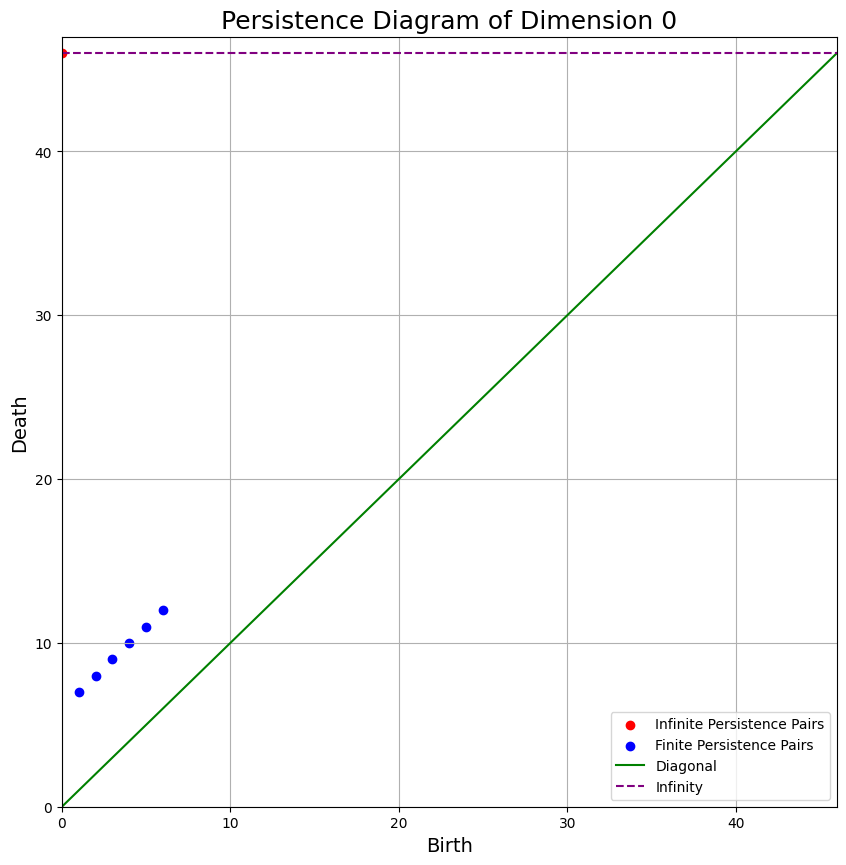

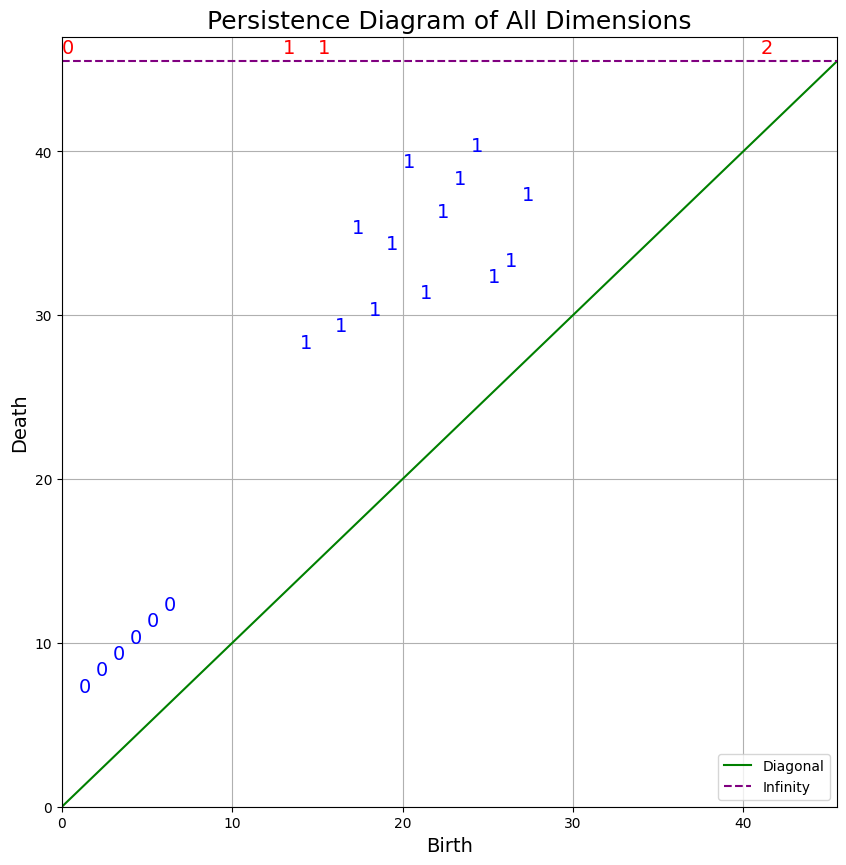

In [9]:
plot_persistence_diagram_single_dimension(sc_1,0)
plot_persistence_diagram_all_dimension(sc_1)